In [24]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from alphatoe import plot, game, data
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from functools import partial
from copy import copy
import tqdm
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
weights = torch.load("../scripts/models/prob all 8 layer control-20230718-185339.pt")
with open("../scripts/models/prob all 8 layer control-20230718-185339.json", "r") as f:
    args = json.load(f)

In [3]:
model_cfg = HookedTransformerConfig(
    n_layers=args["n_layers"],
    n_heads=args["n_heads"],
    d_model=args["d_model"],
    d_head=args["d_head"],
    d_mlp=args["d_mlp"],
    act_fn=args["act_fn"],
    normalization_type=args["normalization_type"],
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device=args["device"],
    seed=args["seed"],
)
model = HookedTransformer(model_cfg)
model.load_state_dict(weights)

<All keys matched successfully>

In [4]:
neurons = [5, 117, 160, 195, 248, 342, 384]

loss_fn = F.cross_entropy

def get_neuron_acts(model, seq):
    with torch.no_grad():
        logits, cache = model.run_with_cache(torch.tensor(seq))
    neuron_activations = copy(cache["post", 0][0])
    return neuron_activations

def ablate_one_neuron(neuron, seq):
    def hook(module, input, output):
        result = output.clone()
        result[:, :, neuron] = 0
        return result
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        logits = model(torch.tensor([10]+seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

target = torch.tensor([0.]*9 + [1.]).to("cuda")    

def neuron_ablated_loss(data, neuron):
    
    logits = ablate_one_neuron(neuron, data)[0,-1]
    
    loss = loss_fn(logits, target)
    loss.to("cpu").detach().numpy()
    return loss

In [5]:
df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')
#count uniques in df
first_conditions = Counter(df['first win condition'])
second_conditions = Counter(df['second win condition'])
for key, val in (first_conditions+second_conditions).items():
    if isinstance(key, str):
        print(f'{key}: {val}')



left column: 24228
top left -> bottom right: 38196
top row: 24228
middle column: 24228
bottom left -> top right: 38196
right column: 24228
middle row: 24228
bottom row: 24228


/tmp/ipykernel_6764/4102556678.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


In [7]:
df.head()

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [6]:
with torch.no_grad():
    game = df.iloc[0]['moves played']
    game = torch.tensor(eval(game)).to('cuda')
    print(neuron_ablated_loss(game, 5))
    game = df.iloc[1]['moves played']
    game = torch.tensor(eval(game)).to('cuda')
    print(neuron_ablated_loss(game, 5))
torch.cuda.empty_cache()


/tmp/ipykernel_6764/2039791098.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


tensor(27.6008, device='cuda:0')
tensor(41.1278, device='cuda:0')


In [8]:
#long run time
df_ablation_losses = pd.DataFrame(columns=['moves played']+neurons)
for neuron in tqdm.tqdm(neurons):
    neuron_losses = []
    for game in tqdm.tqdm(df['moves played']):
        game = torch.tensor(eval(game)).to('cuda')
        neuron_losses.append(neuron_ablated_loss(game, neuron).item())
    df_ablation_losses[neuron] = neuron_losses

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_6764/2039791098.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))
100%|██████████| 7/7 [38:47<00:00, 332.48s/it]


In [14]:
df_ablation_losses['moves played'] = df['moves played']
df_ablation_losses['first win condition'] = df['first win condition']
df_ablation_losses['second win condition'] = df['second win condition']

In [15]:
#save csv
df_ablation_losses.to_csv('../data/230801_mlp_neuron_ablations.csv', index=False)

In [28]:
df_ablation_losses.head()

,moves played,5,117,160,195,248,342,384,first win condition,second win condition
0,"[0, 1, 3, 2, 6]",27.600830,25.984032,20.650963,21.021225,24.808592,24.553686,20.650963,left column,NaN
1,"[0, 1, 3, 4, 6]",41.127792,38.450790,37.021679,37.479591,37.021679,44.526112,37.021679,left column,NaN
2,"[0, 1, 3, 5, 6]",40.524685,34.400578,33.738380,33.738380,33.738380,38.221973,33.738380,left column,NaN
3,"[0, 1, 3, 7, 6]",35.960464,36.924595,31.302052,31.302052,31.302052,35.596428,31.302052,left column,NaN
4,"[0, 1, 3, 8, 6]",37.377480,38.659790,33.185169,33.185169,33.185169,34.629082,33.185169,left column,NaN


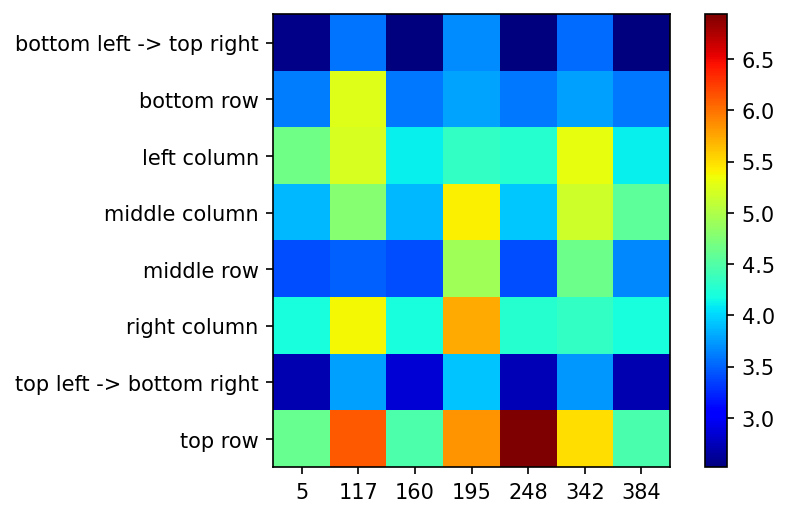

In [36]:
#groupby first win condition
grouped = df_ablation_losses.groupby(['first win condition'])
#imshow the mean of the groupby for each neuron
plt.imshow(grouped.mean(), cmap='jet', interpolation='nearest')
plt.colorbar()
#legend
plt.xticks(np.arange(0, 7), labels=grouped.mean().columns);
#yticks
plt.yticks(np.arange(0, 8), labels=grouped.mean().index);
#dpi
plt.rcParams['figure.dpi'] = 150